In [1]:
using JLD2
using PythonPlot
include("MDPModelFunctions2.jl")

    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonCall/wXfah/CondaPkg.toml
    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonPlot/f591M/CondaPkg.toml
    CondaPkg Dependencies already up to date


plot_over_time_exp2 (generic function with 1 method)

In [88]:
# experiment 1....

# row is 2 obj vs 4 obj
# col is 2 pre-cue, 2 neutral, 2 retro-cue, 2 neutral, 4 pre-cue, 4 neutral, 4 retro-cue, 4 neutral

exp1_cowan_k_true_7_yr = [1.16 1.14 1.13 1.02 2.80 .91 1.30 .96]'
exp1_cowan_k_true_adult = [1.98 1.94 1.97 1.95 3.87 2.66 3.64 2.87]'

# experiment 2 - 4 objects
# col is IM cued, IM neutral, VSTM cued, VSTM neutral

exp2_cowan_k_true_7_yr = [1.55 1.16 1.00 0.69]'
exp2_cowan_k_true_adult = [3.54 2.58 3.58 2.65]'

# experiment 3

# Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
IM_true_7_yr = [1.44 1.27 1.82 0.88]
Short_VSTM_true_7_yr = [1.14 0.77 NaN NaN]
Long_VSTM_true_7_yr = [1.19 0.90 NaN NaN]

exp3_cowan_k_true_7_yr = [IM_true_7_yr; Short_VSTM_true_7_yr; Short_VSTM_true_7_yr]


IM_true_adult = [2.63 2.41 4.80 2.46]
Short_VSTM_true_adult = [2.75 2.38 3.97 2.15]
Long_VSTM_true_adult = [2.76 2.30 3.65 1.75]

exp3_cowan_k_true_adult = [IM_true_adult; Short_VSTM_true_adult; Short_VSTM_true_adult]


3×4 Matrix{Float64}:
 2.63  2.41  4.8   2.46
 2.75  2.38  3.97  2.15
 2.75  2.38  3.97  2.15

In [3]:
to_save_folder = "/home/erussek/projects/Memory_Models/shimi_1_run1"

function load_results(epsilon, N_Quanta, NT_per_Second; exp_num = 2, on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/shimi_all_parameter_search"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/code/Memory_Models/shimi_all_parameter_search/exp$(exp_num)"
    end
    
    local file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second).jld2"
    
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    # print(res)
    
    return res["job_res_$(exp_num)"]
end

function format_res_cowan_k(res; exp_num = 1)
    
    if exp_num == 1
    
        # row is 2 obj vs 4 obj
        # col is pre-cue, neutral, retro-cue, neutral
        
        part_pcorr = res;
        model_cowan_p_corr = [part_pcorr; part_pcorr[2,:]']'
        model_cowan_k_mtx = cowan_k(model_cowan_p_corr, 2)
        model_cowan_k_mtx[2,:] = cowan_k(model_cowan_p_corr[2,:], 4)
        
        model_cowan_k = [model_cowan_k_mtx[1,:]' model_cowan_k_mtx[2,:]']';#[model_cowan_k_mtx[1,:] model_cowan_k_mtx[2,:]]
    elseif exp_num == 2
        
        # IM cued, IM neutral, VSTM cued, VSTM neutral - need to adjust from what it was saved as
        
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = res
        model_cowan_k = cowan_k([p_short_retro p_short_neutral p_long_retro p_long_neutral],4)'
        
    else
        
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = res

        # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
        IM_model = [cowan_k(p_IM_retro[1],3) cowan_k(p_IM_neutral[1],3) cowan_k(p_IM_retro[2],6) cowan_k(p_IM_neutral[2], 6)]
        Short_VSTM_model = [cowan_k(p_VSTM_retro[1],3) cowan_k(p_VSTM_neutral[1],3) cowan_k(p_VSTM_retro[2],6) cowan_k(p_VSTM_neutral[2], 6)]
        Long_VSTM_model = [cowan_k(p_Long_VSTM_retro[1],3) cowan_k(p_Long_VSTM_neutral[1],3) cowan_k(p_Long_VSTM_retro[2],6) cowan_k(p_Long_VSTM_neutral[2], 6)]

        # 3 x 4
        model_cowan_k = [IM_model; Short_VSTM_model; Long_VSTM_model]  
        
    end
        
    return model_cowan_k
    
end    

function load_cowan_k(epsilon, N_Quanta, NT_per_Second; exp_num = 2, on_cluster = false)
    
    res = load_results(epsilon, N_Quanta, NT_per_Second; exp_num = exp_num, on_cluster = false)
    
    model_cowan_k = format_res_cowan_k(res; exp_num = exp_num)
    
    return model_cowan_k
    
end



load_cowan_k (generic function with 1 method)

In [201]:
eps_vals = 0:.05:1
N_eps  = length(eps_vals)

# quanta values
q_vals = 2:2:80
N_q = length(q_vals)

# 
NT_vals = [100, 200, 400, 800]
N_nt = length(NT_vals)


mse_res = Dict()
for exp_num in 1:3
    mse_res[exp_num] = Dict()
    mse_res[exp_num]["child"] = zeros(N_eps, N_q, N_nt)
    mse_res[exp_num]["adult"] = zeros(N_eps, N_q, N_nt)
end


for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
        for (nt_idx, NT_per_Second) in enumerate(NT_vals)
            
            for exp_num = 1:3
                
                model_cowan_k = load_cowan_k(epsilon, N_Quanta, NT_per_Second; exp_num = exp_num, on_cluster = false)
                
                if exp_num == 1
                
                    child_mse = sum((model_cowan_k .- exp1_cowan_k_true_7_yr).^2)
                    adult_mse = sum((model_cowan_k .- exp1_cowan_k_true_adult).^2)
                    
                elseif exp_num == 2
                    
                    child_mse = sum((model_cowan_k .- exp2_cowan_k_true_7_yr).^2)
                    adult_mse = sum((model_cowan_k .- exp2_cowan_k_true_adult).^2)
                    
                else
                    
                    child_sq_err = (model_cowan_k[:] .- exp3_cowan_k_true_7_yr[:]).^2
                    child_mse = sum(child_sq_err[.!isnan.(child_sq_err)])
                    adult_mse = sum((model_cowan_k .- exp3_cowan_k_true_adult).^2)
                    
                end
                
                mse_res[exp_num]["child"][ep_idx, q_idx, nt_idx] = child_mse
                mse_res[exp_num]["adult"][ep_idx, q_idx, nt_idx] = adult_mse

            end
        end
    end
end


In [210]:
# pick the best NT that minimizes both measures...

mse_child =  mse_res[1]["child"] + mse_res[2]["child"] + mse_res[3]["child"]
mse_adult =  mse_res[1]["adult"] + mse_res[2]["adult"] + mse_res[3]["adult"]

min_error_child_by_nt = zeros(N_nt)
min_error_adult_by_nt = zeros(N_nt)

for (nt_idx, NT_per_Second) in enumerate(NT_vals)
    
    min_error_child_by_nt[nt_idx] = minimum(mse_child[:,:,nt_idx])
    min_error_adult_by_nt[nt_idx] = minimum(mse_adult[:,:,nt_idx])

    #min_error_adult_by_nt[nt_idx] = 
    
end


In [208]:
min_error_child_by_nt

4-element Vector{Float64}:
 0.9664871440314373
 0.8093593459039434
 0.7666674338891257
 0.6667385541132397

In [211]:
min_error_adult_by_nt

4-element Vector{Float64}:
 2.506449693072434
 2.1566755288882744
 1.6397143130386662
 1.3883145303361593

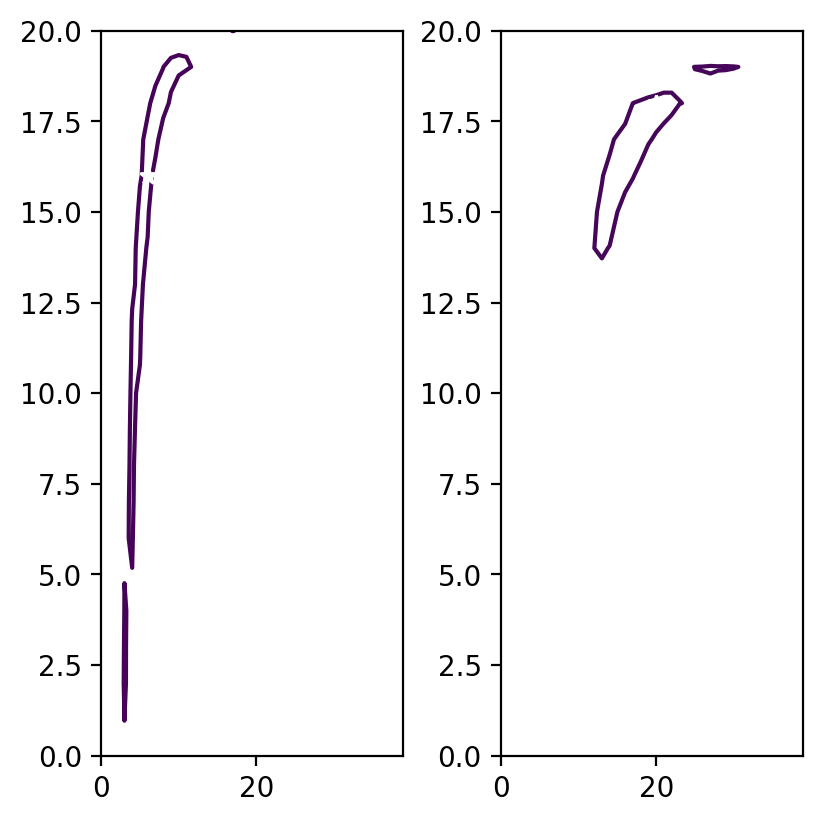

In [5]:
fig,ax = subplots(1, 2,figsize = (4,4), dpi=200,constrained_layout=true)

for (group_idx,which_group) in  enumerate(["child", "adult"])

    this_mse =  mse_res[1][which_group] + mse_res[2][which_group] + mse_res[3][which_group]
    this_mse =  mse_res[3][which_group]

    vmin = minimum(this_mse)
    vmax = maximum(this_mse)
    
    this_val = percentile(this_mse[:,:,end][:], 3)

    c = ax[group_idx-1].contour(this_mse[:,:,end], levels=[this_val], vmin=vmin, vmax=vmax)
    min_idx = argmin(this_mse[:,:,end])
    ax[group_idx-1].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "white")
end




In [392]:
size(this_mse)

(21, 40, 4)

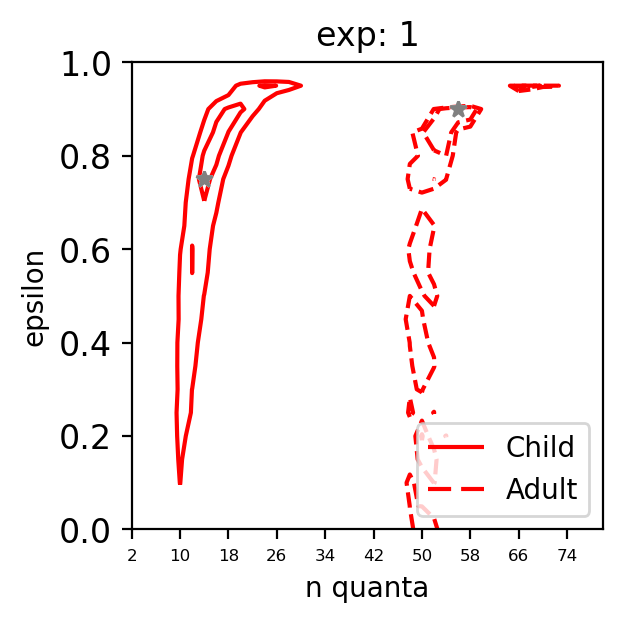

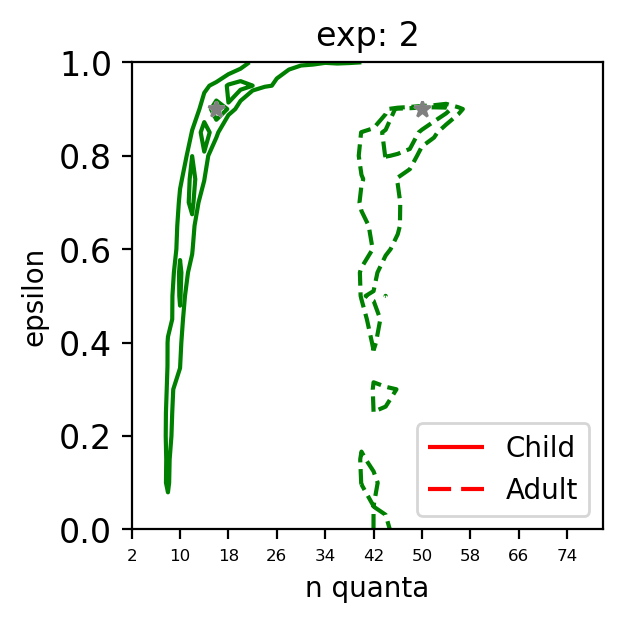

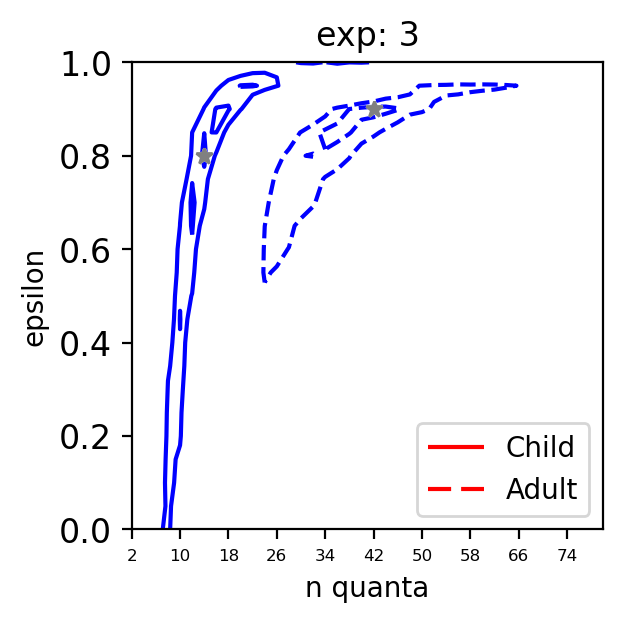

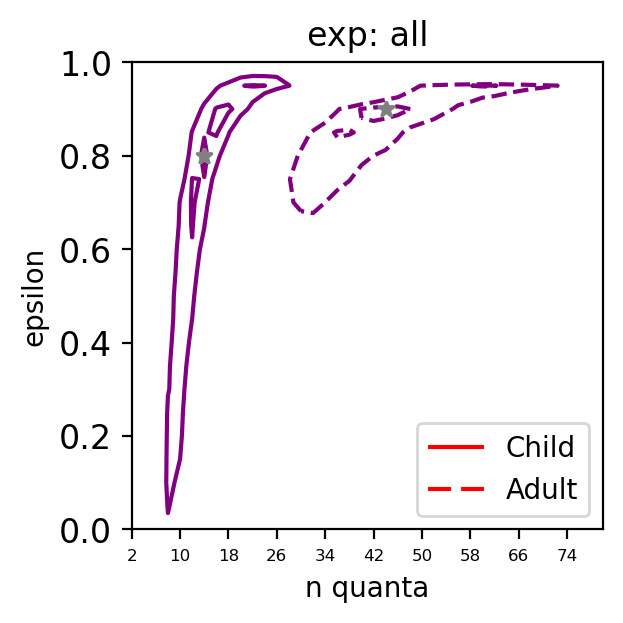

In [85]:
exp_colors = ["r", "g", "b", "purple"]

hs = []



exp_nums = [1,2,3,"all"]

group_ls = ["-", "--"]

# fig,ax = subplots(1,figsize = (3,3), dpi=200,constrained_layout=true)

# save the best params for each experiment...
best_params = Dict()
for exp_num in exp_nums
    best_params[exp_num] = Dict()
end

for (exp_idx, exp_num) in enumerate(exp_nums)
    fig,ax = subplots(1,figsize = (3,3), dpi=200,constrained_layout=true)

    for (group_idx,which_group) in  enumerate(["child", "adult"])

        if exp_num == "all"

            this_mse =  mse_res[1][which_group] + mse_res[2][which_group] + mse_res[3][which_group]
        else
            this_mse =  mse_res[exp_num][which_group]
        end

        vmin = minimum(this_mse[:,:,which_TM])
        vmax = maximum(this_mse[:,:,which_TM])

        this_val_1 = percentile(this_mse[:,:,which_TM][:],1)
        this_val_5 = percentile(this_mse[:,:,end][:], 5)


        c = ax.contour(this_mse[:,:,which_TM], levels=[this_val_1], linestyles = group_ls[group_idx], vmin=vmin, vmax=vmax, colors = (exp_colors[exp_idx]))
        c = ax.contour(this_mse[:,:,which_TM], levels=[this_val_5], linestyles = group_ls[group_idx], vmin=vmin, vmax=vmax, colors = (exp_colors[exp_idx]))

        min_idx = argmin(this_mse[:,:,which_TM])
        ax.plot(min_idx[2]-1, min_idx[1]-1, '*', color = "white")
        
        best_params[exp_num][which_group] = Dict()
        best_params[exp_num][which_group]["epsilon"] = eps_vals[min_idx[1]]
        best_params[exp_num][which_group]["N_Quanta"] = q_vals[min_idx[2]]        

        h,_ = c.legend_elements()
        push!(hs,h[0])

        min_idx = argmin(this_mse[:,:,which_TM])
        ax.plot(min_idx[2]-1, min_idx[1]-1, '*', color = "gray")


    end
    ax.set_yticks(0:4:(N_eps-1))
    ax.set_yticklabels(eps_vals[1:4:end], fontsize=12)
    ax.set_xticks(0:4:(N_q-1))
    ax.set_xticklabels(q_vals[1:4:end], fontsize=6)

    ax.set_ylabel("epsilon")
    ax.set_xlabel("n quanta")
    ax.legend(hs, ["Child", "Adult"], loc="lower right")
    
    ax.set_title(string("exp: " , exp_num))
end


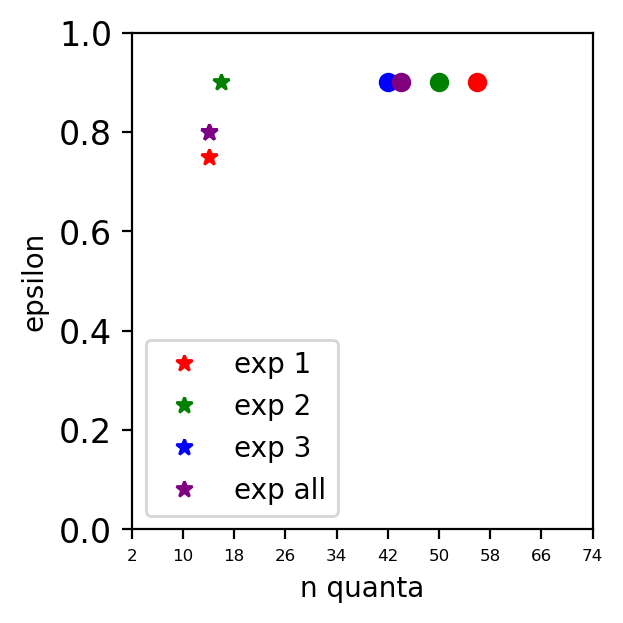

Python: <matplotlib.legend.Legend object at 0x29fc32570>

In [196]:
exp_colors = ["r", "g", "b", "purple"]

hs = []


which_TM = 4

exp_nums = [1,2,3, "all"]

group_ls = ["-", "--"]

fig,ax = subplots(1,figsize = (3,3), dpi=200,constrained_layout=true)

# save the best params for each experiment...
best_params = Dict()
for exp_num in exp_nums
    best_params[exp_num] = Dict()
end

for (exp_idx, exp_num) in enumerate(exp_nums)
    #fig,ax = subplots(1,figsize = (3,3), dpi=200,constrained_layout=true)

    for (group_idx,which_group) in  enumerate(["child", "adult"])

        if exp_num == "all"

            this_mse =  mse_res[1][which_group] + mse_res[2][which_group] + mse_res[3][which_group]
        else
            this_mse =  mse_res[exp_num][which_group]
        end

        vmin = minimum(this_mse[:,:,which_TM])
        vmax = maximum(this_mse[:,:,which_TM])

        this_val_1 = percentile(this_mse[:,:,which_TM][:],1)
        this_val_5 = percentile(this_mse[:,:,end][:], 5)


        #c = ax.contour(this_mse[:,:,which_TM], levels=[this_val_1], linestyles = group_ls[group_idx], vmin=vmin, vmax=vmax, colors = (exp_colors[exp_idx]))
        #c = ax.contour(this_mse[:,:,which_TM], levels=[this_val_5], linestyles = group_ls[group_idx], vmin=vmin, vmax=vmax, colors = (exp_colors[exp_idx]))

        min_idx = argmin(this_mse[:,:,which_TM])
        
        if which_group == "adult"
        
            ax.plot(min_idx[2]-1, min_idx[1]-1, 'o', color = exp_colors[exp_idx])
        else
            ax.plot(min_idx[2]-1, min_idx[1]-1, '*', color =exp_colors[exp_idx], label = string("exp ", exp_num))
        end
        
        best_params[exp_num][which_group] = Dict()
        best_params[exp_num][which_group]["epsilon"] = eps_vals[min_idx[1]]
        best_params[exp_num][which_group]["N_Quanta"] = q_vals[min_idx[2]]        

        #h,_ = c.legend_elements()
        #push!(hs,h[0])

        #min_idx = argmin(this_mse[:,:,which_TM])
        #ax.plot(min_idx[2]-1, min_idx[1]-1, '*', color = "gray")


    end
    ax.set_yticks(0:4:(N_eps-1))
    ax.set_yticklabels(eps_vals[1:4:end], fontsize=12)
    ax.set_xticks(0:4:(N_q-1))
    ax.set_xticklabels(q_vals[1:4:end], fontsize=6)

    ax.set_ylabel("epsilon")
    ax.set_xlabel("n quanta")
    ax.legend(hs, ["Child", "Adult"], loc="lower right")
        
end

ax.legend()


In [187]:
# plot bars for experiment 1... 

function exp1_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")
    x_vals = Vector(1:4) .- .2
    y_vals = [this_cowan_k[[1 3]] this_cowan_k[[5 7]]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:4) .+ .2
    y_vals = [this_cowan_k[[2 4]] this_cowan_k[[6 8]]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")
    ax.set_ylim(0,4)

    ax.set_xticks(1:4)
    ax.set_xticklabels(["Load2Pre", "Load2Retro", "Load4Pre", "Load4Retro"], rotation = 90)
    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
end



exp1_plot_cowan_k_bars (generic function with 1 method)

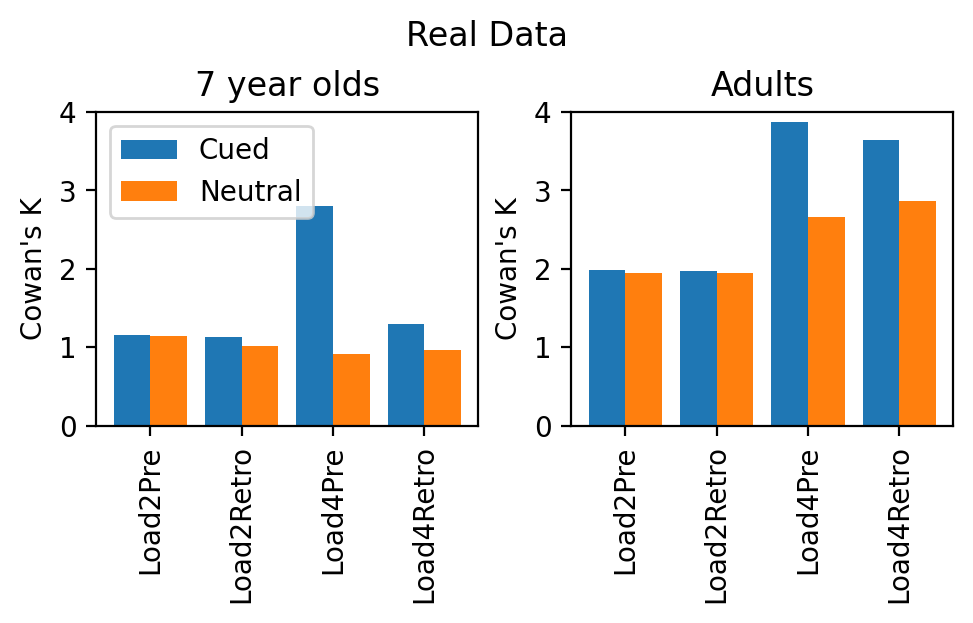

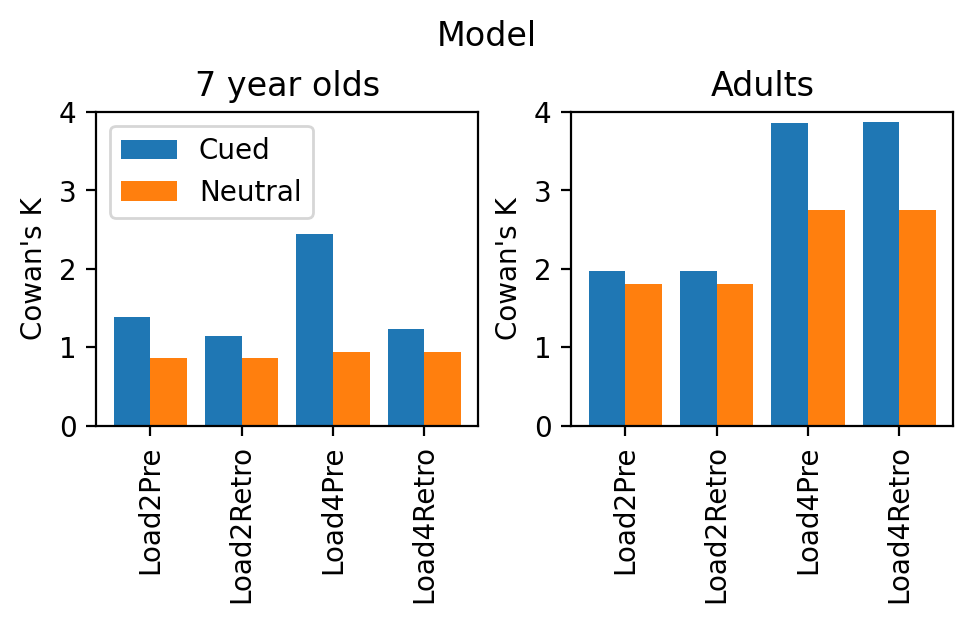

In [188]:
fig,ax = subplots(1, 2,  figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=false)

exp1_plot_cowan_k_bars(exp1_cowan_k_true_7_yr, ax[0])
exp1_plot_cowan_k_bars(exp1_cowan_k_true_adult, ax[1], group_name = "Adults")
ax[0].legend(loc = "upper left")
fig.suptitle("Real Data")

fig,ax = subplots(1, 2,  figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=false)

exp1_cowan_k_model_adult = load_cowan_k(best_params["all"]["adult"]["epsilon"], best_params[1]["adult"]["N_Quanta"], 800; exp_num = 1, on_cluster = false)
exp1_cowan_k_model_7_yr = load_cowan_k(best_params["all"]["child"]["epsilon"], best_params[1]["child"]["N_Quanta"], 800; exp_num = 1, on_cluster = false)

exp1_plot_cowan_k_bars(exp1_cowan_k_model_7_yr, ax[0])
exp1_plot_cowan_k_bars(exp1_cowan_k_model_adult, ax[1], group_name = "Adults")
ax[0].legend(loc = "upper left")
fig.suptitle("Model");


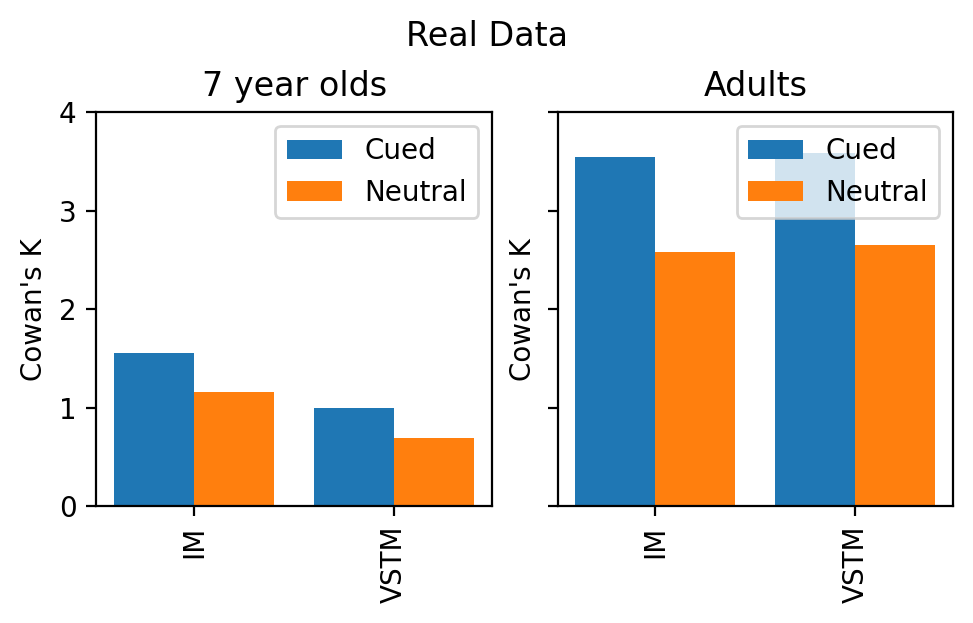

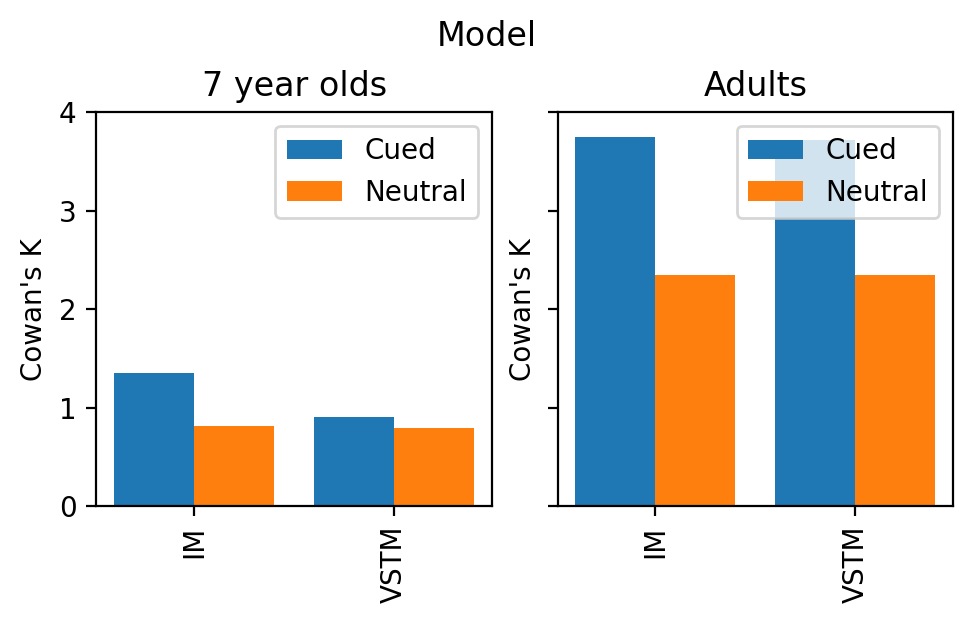

Python: Text(0.5, 0.98611, 'Model')

In [189]:
function exp2_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")
    
    x_vals = Vector(1:2) .- .2
    y_vals = this_cowan_k[[1 3]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:2) .+ .2
    y_vals = this_cowan_k[[2 4]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")
    ax.set_ylim(0,4)

    ax.legend()

    ax.set_xticks(1:2)
    ax.set_xticklabels(["IM", "VSTM"], rotation = 90)

    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
    
end


# neutral performance isn't falling over time at low number of quanta... 
# maybe this reflects 

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)
exp2_plot_cowan_k_bars(exp2_cowan_k_true_7_yr, ax[0])
exp2_plot_cowan_k_bars(exp2_cowan_k_true_adult, ax[1], group_name = "Adults")
fig.suptitle("Real Data")

exp2_cowan_k_model_adult = load_cowan_k(best_params["all"]["adult"]["epsilon"], best_params["all"]["adult"]["N_Quanta"], 800; exp_num = 2, on_cluster = false)
exp2_cowan_k_model_7_yr = load_cowan_k(best_params["all"]["child"]["epsilon"], best_params["all"]["child"]["N_Quanta"], 800; exp_num = 2, on_cluster = false)

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp2_plot_cowan_k_bars(exp2_cowan_k_model_7_yr, ax[0])
exp2_plot_cowan_k_bars(exp2_cowan_k_model_adult, ax[1], group_name = "Adults")
fig.suptitle("Model")


In [190]:
# few figures from experiment 3...

# Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
IM_true_7_yr = [1.44 1.27 1.82 0.88]
Short_VSTM_true_7_yr = [1.14 0.77 NaN NaN]
Long_VSTM_true_7_yr = [1.19 0.90 NaN NaN]

exp3_cowan_k_true_7_yr = [IM_true_7_yr; Short_VSTM_true_7_yr; Short_VSTM_true_7_yr]


3×4 Matrix{Float64}:
 1.44  1.27    1.82    0.88
 1.14  0.77  NaN     NaN
 1.14  0.77  NaN     NaN

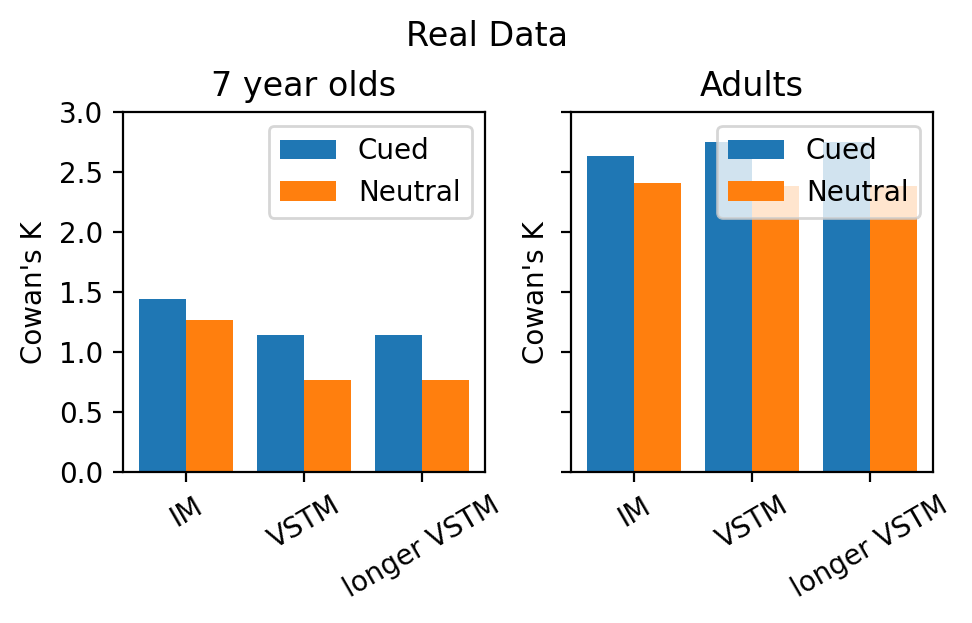

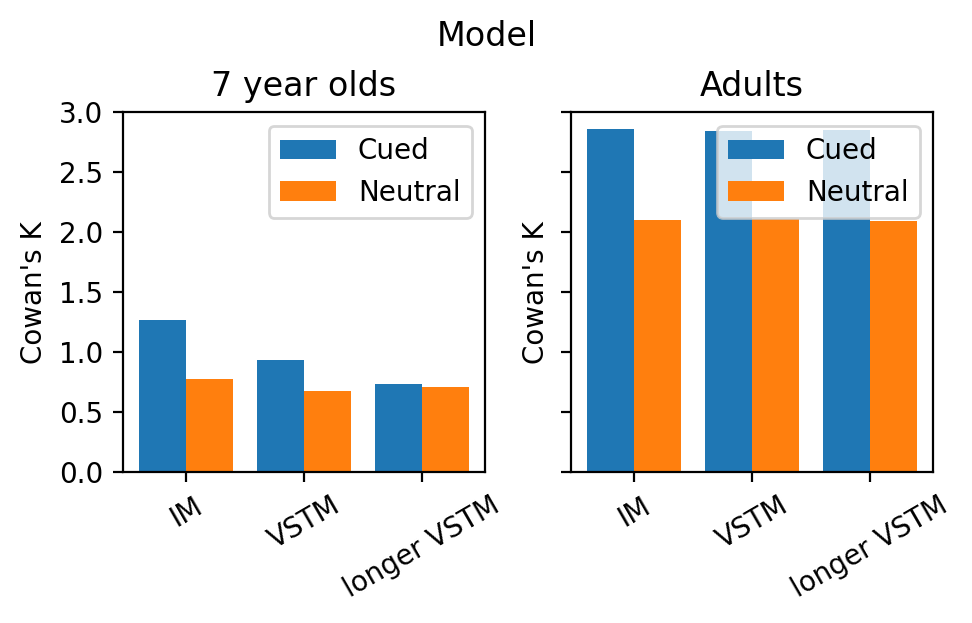

Python: Text(0.5, 0.98611, 'Model')

In [191]:
# this is Cued -  IM, VSTM, Long
function exp3a_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")

    cued_cowan_k_load_3 =  this_cowan_k[:,1]
    neutral_cowan_k_load_3 =  this_cowan_k[:,2]


    x_vals = Vector(1:3) .- .2
    y_vals = cued_cowan_k_load_3
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:3) .+ .2
    y_vals = neutral_cowan_k_load_3
    ax.bar(x_vals, y_vals, .4, label = "Neutral")

    ax.set_xticks(1:3)

    ax.set_xticklabels(["IM", "VSTM", "longer VSTM"], rotation = 30)

    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
    ax.set_ylim(0,3)


    ax.legend()
end

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)
exp3a_plot_cowan_k_bars(exp3_cowan_k_true_7_yr, ax[0])
exp3a_plot_cowan_k_bars(exp3_cowan_k_true_adult, ax[1], group_name = "Adults")
fig.suptitle("Real Data")


exp3a_cowan_k_model_adult = load_cowan_k(best_params["all"]["adult"]["epsilon"], best_params["all"]["adult"]["N_Quanta"], 800; exp_num = 3, on_cluster = false)
exp3a_cowan_k_model_7_yr = load_cowan_k(best_params["all"]["child"]["epsilon"], best_params["all"]["child"]["N_Quanta"], 800; exp_num = 3, on_cluster = false)

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3a_plot_cowan_k_bars(exp3a_cowan_k_model_7_yr, ax[0])
exp3a_plot_cowan_k_bars(exp3a_cowan_k_model_adult, ax[1], group_name = "Adults")
fig.suptitle("Model")

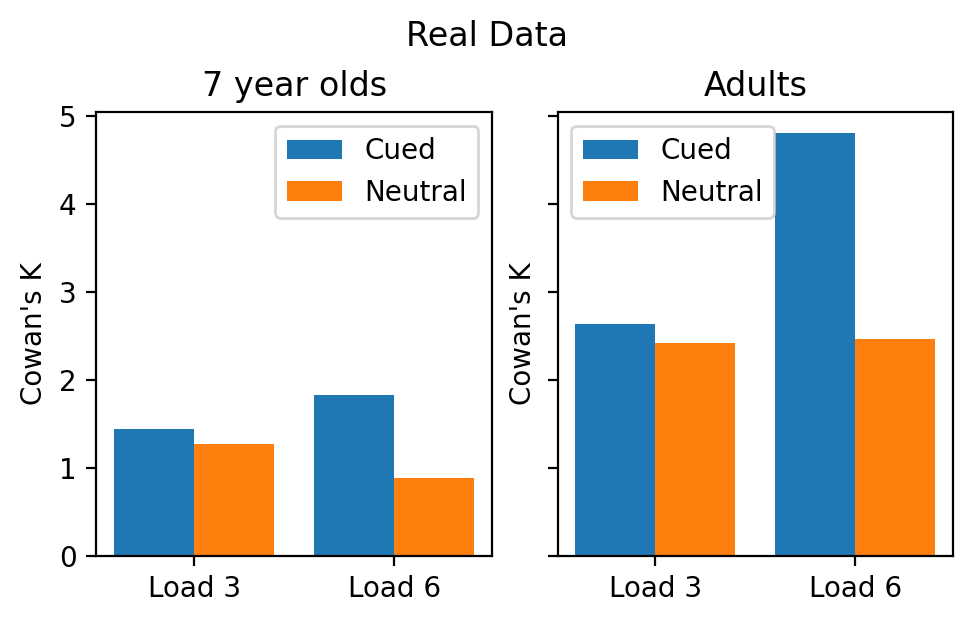

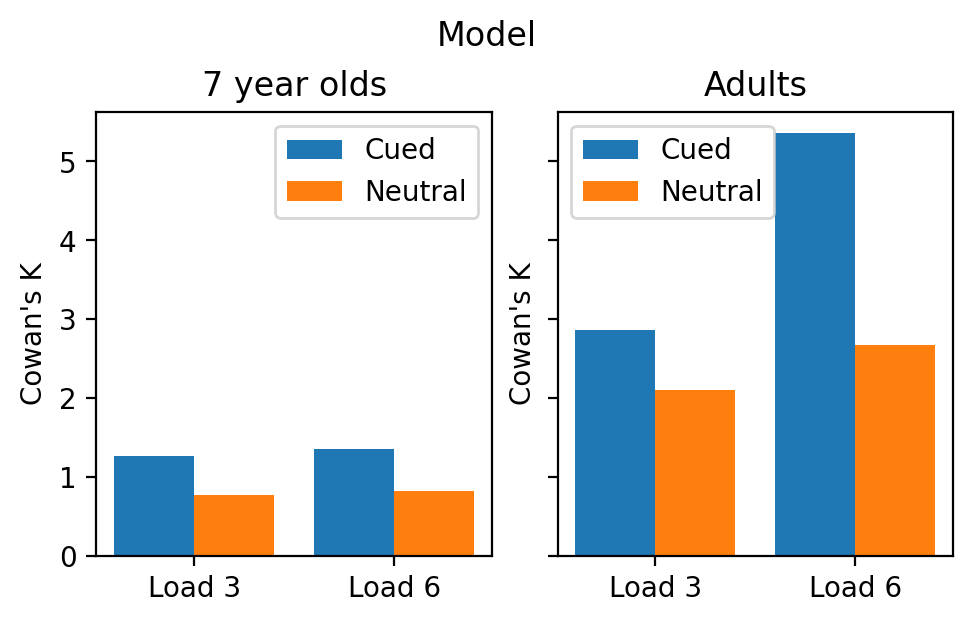

Python: Text(0.5, 0.98611, 'Model')

In [192]:
# next plot... 3b (actually 3c in paper)

# IM

this_cowan_k = exp3_cowan_k_true_7_yr


function exp3b_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")

    # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
    cued_cowan_k_IM = this_cowan_k[1,:]

    x_vals = Vector(1:2) .- .2
    y_vals = cued_cowan_k_IM[[1 3]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:2) .+ .2
    y_vals = cued_cowan_k_IM[[2 4]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")

    ax.legend()

    ax.set_xticks(1:2)
    ax.set_xticklabels(["Load 3", "Load 6"], rotation = 0)

    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
end

# real data
fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)
exp3b_plot_cowan_k_bars(exp3_cowan_k_true_7_yr, ax[0])
exp3b_plot_cowan_k_bars(exp3_cowan_k_true_adult, ax[1], group_name = "Adults")
fig.suptitle("Real Data")

# model
exp3b_cowan_k_model_adult = load_cowan_k(best_params["all"]["adult"]["epsilon"], best_params["all"]["adult"]["N_Quanta"], 800; exp_num = 3, on_cluster = false)
exp3b_cowan_k_model_7_yr = load_cowan_k(best_params["all"]["child"]["epsilon"], best_params["all"]["child"]["N_Quanta"], 800; exp_num = 3, on_cluster = false)

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3b_plot_cowan_k_bars(exp3b_cowan_k_model_7_yr, ax[0])
exp3b_plot_cowan_k_bars(exp3b_cowan_k_model_adult, ax[1], group_name = "Adults")
fig.suptitle("Model")


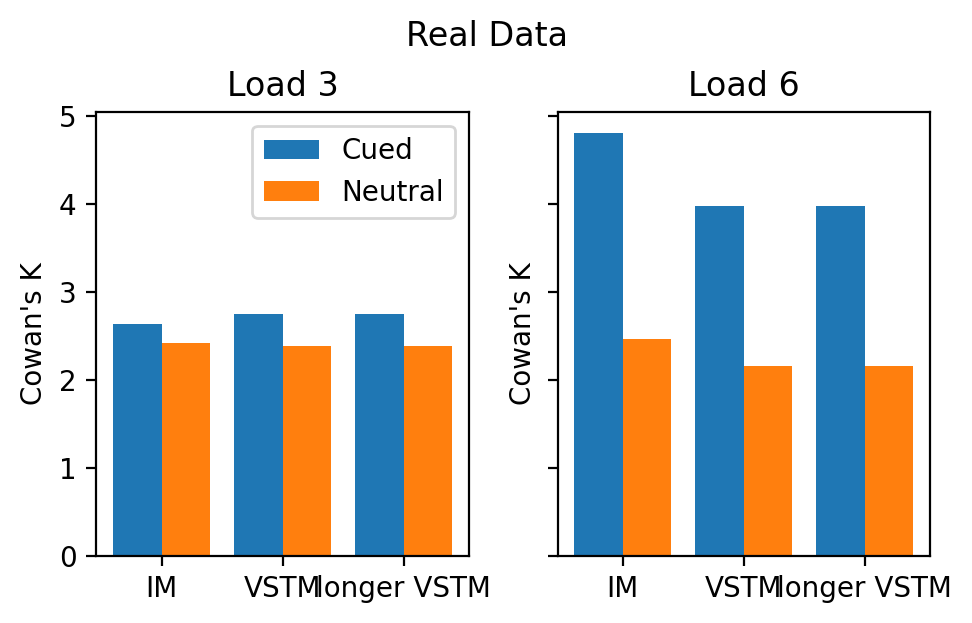

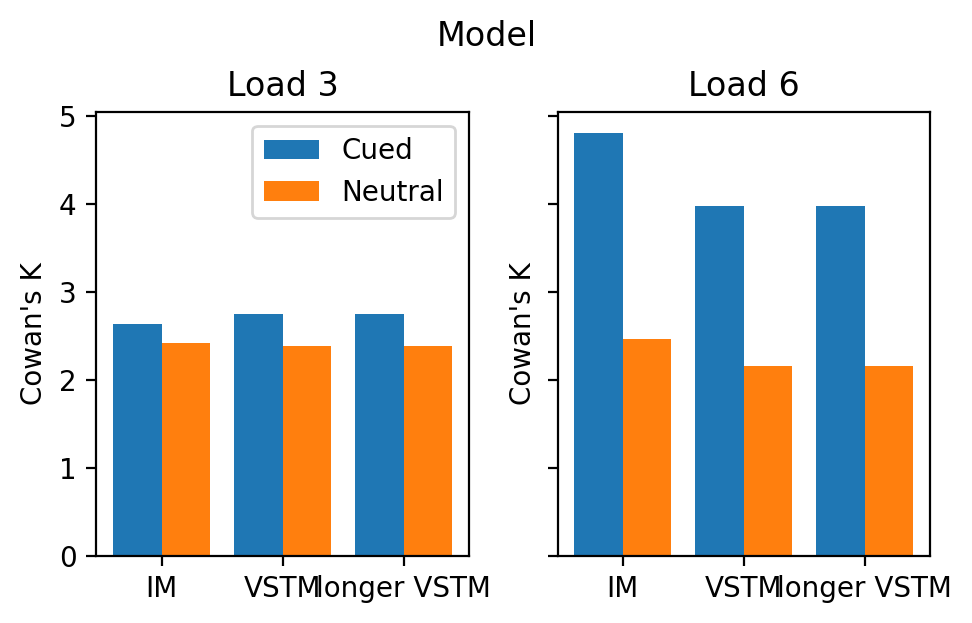

Python: Text(0.5, 0.98611, 'Model')

In [193]:

function exp3c_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")

    # one more plot... just adults...

    this_cowan_k = exp3_cowan_k_true_adult
    this_cowan_k
    # Cols: Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral

    # so first do Load 3 - cued, varying length
    cowan_k_3_cued = this_cowan_k[:,1]
    x_vals = Vector(1:3) .- .2
    y_vals = cowan_k_3_cued
    ax[0].bar(x_vals, y_vals, .4, label = "Cued")

    cowan_k_3_neutral = this_cowan_k[:,2]
    x_vals = Vector(1:3) .+ .2
    y_vals = cowan_k_3_neutral
    ax[0].bar(x_vals, y_vals, .4, label = "Neutral")

    cowan_k_6_cued = this_cowan_k[:,3]
    x_vals = Vector(1:3) .- .2
    y_vals = cowan_k_6_cued
    ax[1].bar(x_vals, y_vals, .4, label = "Cued")

    cowan_k_6_neutral = this_cowan_k[:,4]
    x_vals = Vector(1:3) .+ .2
    y_vals = cowan_k_6_neutral
    ax[1].bar(x_vals, y_vals, .4, label = "Neutral")
    
    ax[0].legend()


    for ax_idx in 0:1
        ax[ax_idx].set_xticks(1:3)
        ax[ax_idx].set_xticklabels(["IM", "VSTM", "longer VSTM"], rotation = 0)
        ax[ax_idx].set_ylabel("Cowan's K")
    end

    ax[0].set_title("Load 3")
    ax[1].set_title("Load 6")

end

fig,ax = subplots(1,2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3c_plot_cowan_k_bars(exp3_cowan_k_true_adult, ax)
fig.suptitle("Real Data")
fig,ax = subplots(1,2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3c_plot_cowan_k_bars(exp3_cowan_k_model_adult,ax)
fig.suptitle("Model")
